In [1]:
import pandas as pd
import numpy as np
from dsipts import TimeSeries, RNN,read_public_dataset, LinearTS, Persistent, TFT
import matplotlib.pyplot as plt
from datetime import timedelta
import logging
import sys
import random



In [2]:
def random_walk(n,level=20):
    tot = np.zeros(n)
    probs = np.zeros(n)
    for i in range(n-1):
        prob = random.random()
        if prob<0.5:
            delta = 1
        else:
            delta = -1
        tot[i+1] = tot[i] + delta
        probs[i+1]= prob+(random.random()/level-0.5/level)
    return tot, probs
N = 20000
random.seed(18)
x, p = random_walk(N)
data = pd.DataFrame({'y':x/x.max(),'p':p,'time':range(N)})

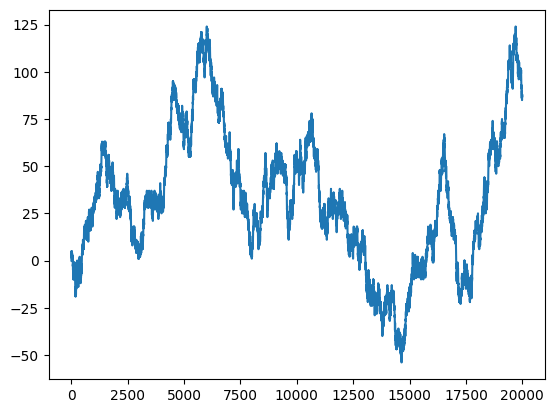

In [3]:
plt.plot(x)

In [4]:
##loasklearnthe timeseries to the datastructure, adding the hour column and use all the covariates
ts = TimeSeries('weather')
ts.load_signal(data,enrich_cat=[],target_variables=['y'],past_variables= [],future_variables=['p'])
ts

Timeseries named weather of length 20000.
 Categorical variable: [],
 Future variables: ['p'],
 Past variables: ['y'],
 Target variables: ['y']
 With no group

In [5]:
#Let now prepare a model predictin the next 16 step using the past 16 steps 
past_steps = 1
future_steps = 36


In [6]:
##splitting parameters
split_params = {'perc_train':0.6,'perc_valid':0.2,                             ##if not None it will split 70% 10% 20%
               'range_train':None, 'range_validation':None, 'range_test':None, ## or we can split using ranges for example range_train=['2021-02-03','2022-04-08']
               'past_steps':past_steps,
               'future_steps':future_steps,
               'shift':1,
                'keep_entire_seq_while_shifting':False,
               'starting_point':None,                                          ## do not skip samples
               'skip_step' : 1                                                 ## distance between two consecutive samples
                             }

In [ ]:
res_tot = {}
for w in np.arange(0,25,5):

    config = dict(model_configs =dict(
                                        past_steps = past_steps,
                                        future_steps = future_steps,
                                        past_channels = len(ts.past_variables),
                                        future_channels = len(ts.future_variables),
                                        embs = [ts.dataset[c].nunique() for c in ts.cat_var],
                                          d_model=64,
                                          d_head= 64,
                                          n_head=36,
                                         dropout_rate = 0.1,
                                          num_layers_RNN= 16,
                                          optim='torch.optim.Adam',
                                         out_channels = len(ts.target_variables),
                                        quantiles= [],
                                       loss_type='exponential_penalization',
                                     persistence_weight = w,
                                        ),
                    scheduler_config = dict(gamma=0.1,step_size=2400000000000),
                    optim_config = dict(lr = 0.00005,weight_decay=0.0))
    model_linear = TFT(**config['model_configs'],optim_config = config['optim_config'],scheduler_config =config['scheduler_config'],verbose=False )
    #set the desirere model
    ts.set_model(model_linear,config=config,custom_init=True )
    ts.train_model(dirpath=f"/home/agobbi/Projects/ExpTS/rf/tft",
               split_params=split_params,
               batch_size=32,
               num_workers=2,
               max_epochs=25,
               auto_lr_find=True)
    #make inferences on 
    res = ts.inference_on_set(200,4,set='test',rescaling=True)
    res['prediction_time'] = res.apply(lambda x: int(x.time-x.lag), axis=1)
    res_tot[w] = res.copy()

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/agobbi/Projects/ExpTS/rf/tft exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.008317637711026709
Restoring states from the checkpoint path at /home/agobbi/Projects/ExpTS/rf/tft/.lr_find_a8812af0-c922-4eaa-9c5d-282e33f3f2e0.ckpt
Restored all states from the checkpoint file at /home/agobbi/Projects/ExpTS/rf/tft/.lr_find_a8812af0-c922-4eaa-9c5d-282e33f3f2e0.ckpt

   | Name                   | Type                    | Params
--------------------------------------------------------------------
0  | target_linear          | Linear                  | 128   
1  | linear_aux_past        | ModuleList              | 0     
2  | linear_aux_fut         | ModuleList              | 128   
3  | emb_cat_var            | embedding_cat_variables | 4.9 K 
4  | rnn                    | LSTM_Model              | 534 K 
5  | res_conn1_past         | ResidualConnection      | 8.3 K 
6  | res_conn1_fut          | ResidualConnection      | 8.3 K 
7  | grn1_past              | GRN                     | 16.6 K
8  | grn

Saving losses on file because multigpu not working


Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/agobbi/Projects/ExpTS/rf/tft exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 8.317637711026709e-07
Restoring states from the checkpoint path at /home/agobbi/Projects/ExpTS/rf/tft/.lr_find_daabaee4-bbc5-49f7-834e-d15eeb1e4fa8.ckpt
Restored all states from the checkpoint file at /home/agobbi/Projects/ExpTS/rf/tft/.lr_find_daabaee4-bbc5-49f7-834e-d15eeb1e4fa8.ckpt

   | Name                   | Type                    | Params
--------------------------------------------------------------------
0  | target_linear          | Linear                  | 128   
1  | linear_aux_past        | ModuleList              | 0     
2  | linear_aux_fut         | ModuleList              | 128   
3  | emb_cat_var            | embedding_cat_variables | 4.9 K 
4  | rnn                    | LSTM_Model              | 534 K 
5  | res_conn1_past         | ResidualConnection      | 8.3 K 
6  | res_conn1_fut          | ResidualConnection      | 8.3 K 
7  | grn1_past              | GRN                     | 16.6 K
8  | gr

Saving losses on file because multigpu not working


Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/agobbi/Projects/ExpTS/rf/tft exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.025118864315095822
Restoring states from the checkpoint path at /home/agobbi/Projects/ExpTS/rf/tft/.lr_find_409822f4-36a7-4edb-a5b7-a33eb0d38be9.ckpt
Restored all states from the checkpoint file at /home/agobbi/Projects/ExpTS/rf/tft/.lr_find_409822f4-36a7-4edb-a5b7-a33eb0d38be9.ckpt

   | Name                   | Type                    | Params
--------------------------------------------------------------------
0  | target_linear          | Linear                  | 128   
1  | linear_aux_past        | ModuleList              | 0     
2  | linear_aux_fut         | ModuleList              | 128   
3  | emb_cat_var            | embedding_cat_variables | 4.9 K 
4  | rnn                    | LSTM_Model              | 534 K 
5  | res_conn1_past         | ResidualConnection      | 8.3 K 
6  | res_conn1_fut          | ResidualConnection      | 8.3 K 
7  | grn1_past              | GRN                     | 16.6 K
8  | grn

Saving losses on file because multigpu not working


Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/agobbi/Projects/ExpTS/rf/tft exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/agobbi/.conda/envs/tt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.017378008287493765
Restoring states from the checkpoint path at /home/agobbi/Projects/ExpTS/rf/tft/.lr_find_ead36fe3-b877-49ee-a2be-490ab3bde7ca.ckpt
Restored all states from the checkpoint file at /home/agobbi/Projects/ExpTS/rf/tft/.lr_find_ead36fe3-b877-49ee-a2be-490ab3bde7ca.ckpt

   | Name                   | Type                    | Params
--------------------------------------------------------------------
0  | target_linear          | Linear                  | 128   
1  | linear_aux_past        | ModuleList              | 0     
2  | linear_aux_fut         | ModuleList              | 128   
3  | emb_cat_var            | embedding_cat_variables | 4.9 K 
4  | rnn                    | LSTM_Model              | 534 K 
5  | res_conn1_past         | ResidualConnection      | 8.3 K 
6  | res_conn1_fut          | ResidualConnection      | 8.3 K 
7  | grn1_past              | GRN                     | 16.6 K
8  | grn

In [29]:
error = {}
for k in res_tot.keys():
    error[k] = res_tot[k].groupby('lag').apply(lambda x: np.sqrt(np.mean((x.y_pred-x.y)**2))).reset_index()
    plt.plot(error[k].lag, error[k][0],label=k)
plt.legend()

In [72]:
#train the model for 50 epochs with auto_lr_find 


In [21]:
#Print the losses, check overfitting
ts.losses.plot()

<Axes: >

In [25]:
plt.figure()
date = 19932
for i,k in enumerate(res_tot.keys()):
    res_tot[k]['prediction_time'] = res_tot[k].apply(lambda x: int(x.time-x.lag), axis=1)
    if i ==0:
        plt.plot( res_tot[k][ res_tot[k].prediction_time==date].time,  res_tot[k][ res_tot[k].prediction_time==date].y,label='real',alpha=0.5)
    plt.plot( res_tot[k][ res_tot[k].prediction_time==date].time,  res_tot[k][ res_tot[k].prediction_time==date].y_pred,label=k,alpha=0.5)
plt.legend()

In [26]:
for k in res_tot:
    print(k,res_tot[k].groupby('lag').apply(lambda x: np.nanmean((x.y-x.y_pred)**2)).reset_index().rename(columns={0:'error'}).error.mean())

0 0.0013719359
5 0.001369641
10 0.0013747527
15 0.001375372
20 0.0013751936
